# Intro: BotOp (Robot Operation) interface

BotOp (=robot operation) defines a very narrow interface to control a real or simulated robot. While in initial years we tried all kinds of other interfaces (ROS-given, operational space control interfaces, controller state machines, etc), this one seems most pragmatic, simple, transparent, and compatible to our research work at the LIS research team. There is no ROS or complex IPC involved, just a few threads (communicating with hardwares) interfaced via BotOp.

The interface essentially provides move methods to set/overwrite a spline reference for the robot. (Also compliance around the reference can be set.) Gripper methods to operate grippers. And getImage.. methods grab images or point clouds from the camera.

This interface is quite different to a more *generic physical simulation* interface. If you're interested in the latter (e.g. to implement a gym environment) look at the `Simulation` tutorial. BotOp uses a `Simulation` (optionally) as an underlying engine, but is quite different in that it is wrapped as a real-time threaded process that emulates the specific BotOp interface to a real robot -- to make it swappable with a real robot. If BotOp is run in simulation mode, the simulation can be run in many different modes: 
- pure kinematic (no physics for objects)
- a physics simulator with physics for objects but still kinematic robot
- a physic simulator with PD motors for the robot.

## Sending motion based on IK

We'll show how to make the robot move to pre-computed joint space poses, e.g. computed via IK. Later we modify this to *overwriting* the motion reference with high frequency, which essentially realizes MPC-style control.

The first step (also for operating the real robot) is always to load a configuration:

In [1]:
import robotic as ry
import numpy as np
import time

In [2]:
C = ry.Config()
C.addFile(ry.raiPath('../rai-robotModels/scenarios/pandaSingle.g'))
C.view(False, 'this is your workspace data structure C -- NOT THE SIMULTATION')

0

We open a robot interface in simulation (`False`). `True` would directly open communication to one or two pandas (depending no how many are defined in C). The `botsim/verbose` above leads to the explicit verbosity when creating the simulator interface.

In [3]:
bot = ry.BotOp(C, useRealRobot=False)

Note the simulation window, showing that the simulation is running in a thread and the given *control reference time*.

We define 2 reference poses, q0=home and q1=(2nd joint bend), so that we can move back and forth between them:

In [4]:
qHome = bot.get_qHome()
q0 = qHome.copy()
q1 = q0.copy()
q1[1] = q1[1] + .2
print(q0, q1)

[ 0.  -0.5  0.  -2.   0.   2.  -0.5] [ 0.  -0.3  0.  -2.   0.   2.  -0.5]


The `moveTo` is the simplest way to move the robot from current to target. It internally creates a cubic B-spline to the target with optimal timing and follows it. The call is *non-blocking*. Also, your workspace config C is not kept in sync with the real/sim. If you want to wait till the motion is finished, you need to do manually checking the `getTimeToEnd` (=time til the end of the given spline reference), and meanwhile staying sync'ed.

In [5]:
bot.moveTo(q1)

while bot.getTimeToEnd()>0:
    bot.sync(C, .1)

The internal spline reference can be appended: As `moveTo` is non-blocking, you can append several moves like this:

In [6]:
print('timeToEnd:', bot.getTimeToEnd())
bot.moveTo(q0)
print('timeToEnd:', bot.getTimeToEnd())
bot.moveTo(q1)
print('timeToEnd:', bot.getTimeToEnd())
bot.moveTo(q0)

while bot.getTimeToEnd()>0:
    bot.sync(C, .1)

timeToEnd: -0.08228105793499862
timeToEnd: 1.0957189420649807
timeToEnd: 2.191437884129961


## Reactive control: Overwriting the reference

Setting splines becomes reactive, when we can smoothly overwrite the spline reference with high frequency. Technically (internally), smoothly overwriting means to take the current dynamic state (pose, velocity) and create a new cubic B-spline with current state as start and given target as end, with optimal timing.

To demonstrate this let's consider a more involved scenario, where the target is a frame that is randomly moving, and we use repeated IK in each cycle to track it.

In [7]:
#this reference frame only appears in your workspace C - not the simulation!
target = C.addFrame('target', 'table')
target.setShape(ry.ST.marker, [.1])
target.setRelativePosition([0., .3, .3])
pos = target.getPosition()
cen = pos.copy()
C.view()

0

The following defines a very basic Inverse Kinematics method -- you'll learn more about this in the next tutorial.

In [8]:
def IK(C, pos):
    q0 = C.getJointState()
    komo = ry.KOMO(C, 1, 1, 0, False) #one phase one time slice problem, with 'delta_t=1', order=0
    komo.addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], q0) #cost: close to 'current state'
    komo.addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], qHome) #cost: close to qHome
    komo.addObjective([], ry.FS.positionDiff, ['l_gripper', 'target'], ry.OT.eq, [1e1]) #constraint: gripper position
    
    ret = ry.NLP_Solver(komo.nlp(), verbose=0) .solve()
    
    return [komo.getPath()[0], ret]

The following does *not* really move the robot: it is just 'setting' the workspace C to the IK solution. No motion is sent to the real/simulated robot:

In [9]:
for t in range(20):
    time.sleep(.1)
    pos = cen + .98 * (pos-cen) + 0.02 * np.random.randn(3)
    target.setPosition(pos)
    
    q_target, ret = IK(C, pos)
    print(ret)
    C.setJointState(q_target)
    C.view()

{ time: 0.000988, evals: 6, done: 1, feasible: 1, sos: 0.00638374, f: 0, ineq: 0, eq: 0.000792934 }
{ time: 0.000173, evals: 3, done: 1, feasible: 1, sos: 0.00396896, f: 0, ineq: 0, eq: 0.00299929 }
{ time: 0.000222, evals: 3, done: 1, feasible: 1, sos: 0.00350838, f: 0, ineq: 0, eq: 0.00385449 }
{ time: 0.000205, evals: 3, done: 1, feasible: 1, sos: 0.00311271, f: 0, ineq: 0, eq: 0.000981907 }
{ time: 0.000498, evals: 3, done: 1, feasible: 1, sos: 0.00257131, f: 0, ineq: 0, eq: 0.00322534 }
{ time: 0.000147, evals: 2, done: 1, feasible: 1, sos: 0.00240704, f: 0, ineq: 0, eq: 0.00199628 }
{ time: 0.000452, evals: 4, done: 1, feasible: 1, sos: 0.00214793, f: 0, ineq: 0, eq: 0.000309622 }
{ time: 0.000251, evals: 3, done: 1, feasible: 1, sos: 0.00180151, f: 0, ineq: 0, eq: 0.0012835 }
{ time: 0.000208, evals: 4, done: 1, feasible: 1, sos: 0.00226439, f: 0, ineq: 0, eq: 0.000415795 }
{ time: 0.000574, evals: 3, done: 1, feasible: 1, sos: 0.00184439, f: 0, ineq: 0, eq: 0.00174546 }
{ time:

We now generate reative motion by smoothly overwriting the spline reference. Increasing time cost makes it more agressive (penalized total duration of estimated cubic spline).

In [10]:
for t in range(100):
    bot.sync(C, .1) #keep the workspace C sync'ed to real/sim, and idle .1 sec
    pos = cen + .98 * (pos-cen) + 0.02 * np.random.randn(3)
    target.setPosition(pos)
    
    q_target, ret = IK(C, pos)
    bot.moveTo(q_target, timeCost=5., overwrite=True)

## Aborting motion

Good practise is to always allow a user aborting motion execution. In this example, key 'q' will break the loop and call a home() (which is the same as moveTo(qHome, 1., True)

In [11]:
for t in range(5):
    print(t)
    bot.moveTo(q1)
    bot.wait(C) #same as 'loop sync til keypressed or endOfTime', but also raises user window
    if bot.getKeyPressed()==ord('q'):
        print("cancelled")
        break;
        
    bot.moveTo(q0)
    bot.wait(C)
    if bot.getKeyPressed()==ord('q'):
        print("cancelled")
        break;

bot.home(C)

0
1
2
3
4


## Gripper operation

Gripper movements also do not block:

In [12]:
bot.gripperMove(ry._left, width=.01, speed=.2)

while not bot.gripperDone(ry._left):
    bot.sync(C, .1)

bot.gripperMove(ry._left, width=.075, speed=1)

while not bot.gripperDone(ry._left):
    bot.sync(C, .1)

## Camera & Point Could

BotOp also interfaces basic grabbing of image and depth. In simulation model, the sensor name needs to be a frame name that has camera attributes defined. On the real robot, a realsense camera is directly grabbed.

In [13]:
rgb, depth, points = bot.getImageDepthPcl('cameraWrist')

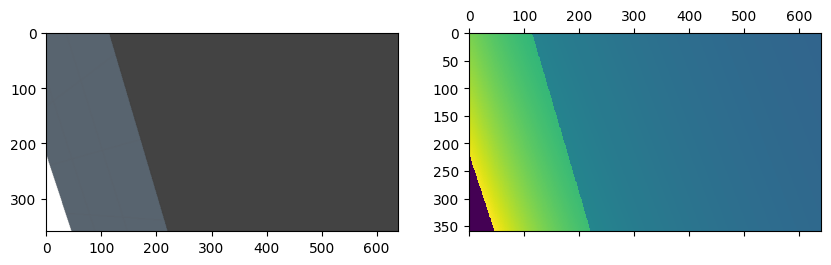

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5))
axs = fig.subplots(1, 2)
axs[0].imshow(rgb)
axs[1].matshow(depth)
plt.show()

The returned `points` are a point could, that was directly computed from the depth image and the camera intrinsics. The intrinsics are given by the focal lengths (f_x, f_y) and image center (c_x, c_y). We can also manually compute the point cloud as follows:

In [15]:
fxycxy = bot.getCameraFxycxy("cameraWrist")
points2 = ry.depthImage2PointCloud(depth, fxycxy)
np.linalg.norm(points - points2)

0.0

The point cloud is given relative to the camera frame. We can display it by creating a dedicates frame, attached to the camera frame, and setting its (purely visual) shape to be the point cloud:

In [16]:
pclFrame = C.addFrame('pcl', 'cameraWrist')
pclFrame.setPointCloud(points, rgb)
pclFrame.setColor([1.,0.,0.]) #only to see it when overlaying with truth
C.view()

0

## Shutdown

You always need to shut down processes (e.g. communication with the real robot) properly. That's done here by explicitly destroying the objects:

In [17]:
del bot
del C

-- bot.cpp:~BotOp:128(0) shutting down BotOp...
-- simulation.cpp:~BotThreadedSim:56(0) shutting down SimThread
-- simulation.cpp:~Simulation:149(0) shutting down Simulation


## Parameters

BotOp (and other parts of the rai code) use all kinds of internal parameters that can be configured. The best way to look which parameters actually are used/relevant is to retrospect print the list of parameters have been queried by the code so far. That gives an idea of which global parameters exist:

In [18]:
ry.params_print()

message: "this parameter was loaded from 'rai.cfg'",
noInteractivity,
bot/blockRealRobot,
bot/useGripper,
bot/useRobotiq!,
bot/useArm: left,
botsim/hyperSpeed: 1,
botsim/verbose: 1,
botsim/engine: physx,
physx/verbose: 1,
physx/yGravity!,
physx/softBody!,
physx/multiBody,
physx/multiBodyDisableGravity,
physx/jointedBodies!,
physx/angularDamping: 0.1,
physx/defaultFriction: 1,
physx/defaultRestitution: 0.1,
physx/motorKp: 1000,
physx/motorKd: 100,
bot/useOptitrack!,
bot/useAudio!,
bot/raiseWindow!,
KOMO/verbose: 1,
KOMO/animateOptimization: 0,
KOMO/mimicStable,
KOMO/unscaleEqIneqReport!,
KOMO/sampleRate_stable: 0,
KOMO/sparse,
opt/verbose: 1,
opt/stopTolerance: 0.01,
opt/stopFTolerance: -1,
opt/stopGTolerance: -1,
opt/stopEvals: 1000,
opt/stopIters: 1000,
opt/stopOuters: 1000,
opt/stopLineSteps: 10,
opt/stopTinySteps: 10,
opt/initStep: 1,
opt/minStep: -1,
opt/maxStep: 0.2,
opt/damping: 1,
opt/stepInc: 1.5,
opt/stepDec: 0.5,
opt/wolfe: 0.01,
opt/boundedNewton,
opt/muInit: 1,
opt/muInc: 5

That might tell you a lot about what happend internally.

In the context of BotOp, the parameter `botsim/engine` can also be set to `kin`, which would create a simulation without physics where merely the robot moves (and grasped object can be attached/detached). The `botsim/verbose` above leads to the explicit verbosity when creating the simulator interface.

Parameters can be set in a local file `rai.cfg`, or manually in python  with the following calls -- but that need's to be done BEFORE BotOp is created.

In [19]:
ry.params_add({'botsim/verbose': 2., 'physx/motorKp': 10000., 'physx/motorKd': 1000.})
ry.params_add({'botsim/engine': 'physx'}) #makes a big difference!
ry.params_add({'physx/multibody': True}) #makes a big difference!